In [1]:
%ls -rtlh

total 32M
-rw-r--r-- 1 dueo dueo    19 Mar 27 21:19 __init__.py
-rw-r--r-- 1 dueo dueo   758 Mar 27 21:19 CreateMatLabConversionCode.R
-rw-r--r-- 1 dueo dueo  1.9K Mar 27 21:19 create_data.py
-rw-r--r-- 1 dueo dueo  164K Apr  2 00:37 training_net1.png
drwxr-xr-x 2 dueo dueo  4.0K Apr  2 01:45 data/
-rw-r--r-- 1 dueo dueo 1009K Apr  2 11:18 creation_of_data.ipynb
-rw-r--r-- 1 dueo dueo  5.2K Apr  2 14:06 FirstTry.py
-rw-r--r-- 1 dueo dueo  4.8K Apr  2 19:13 FirstTry.pyc
-rw-r--r-- 1 dueo dueo  179K Apr  2 19:30 dumm.png
-rw-r--r-- 1 dueo dueo  1.4M Apr  2 20:21 pred.png
drwxr-xr-x 3 dueo dueo  4.0K Jun 23 18:35 MRIManualSegmentation/
-rw-r--r-- 1 dueo dueo  2.0K Jul 16 18:49 Untitled.ipynb
-rw-r--r-- 1 dueo dueo  227K Jul 17 11:37 TEST-CASE.png
-rw-r--r-- 1 dueo dueo   27K Jul 17 19:52 creation_of_data_inselspital.ipynb
-rw-r--r-- 1 dueo dueo  9.1M Jul 17 19:53 GBM_sub.pickle
-rw-r--r-- 1 dueo dueo  1.7M Jul 20 11:13 META_sub.pickle.gz
-rw-r--r-- 1 dueo dueo  109K Jul 20 11:15 DataUnder

In [2]:
import pickle
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time

In [3]:
import lasagne
import nolearn.lasagne
lasagne, nolearn.lasagne

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 780


(<module 'lasagne' from '/usr/local/lib/python2.7/dist-packages/Lasagne-0.1dev-py2.7.egg/lasagne/__init__.pyc'>,
 <module 'nolearn.lasagne' from '/usr/local/lib/python2.7/dist-packages/nolearn-0.6adev-py2.7.egg/nolearn/lasagne/__init__.pyc'>)

### Analysis of the Images (one Tumor per Image)
The aim of this analysis is to test if it is possible to destinguish between the 2 different tumours types. Therefore the net is trained with with the cropped images of the 2 tumour types.

#### Creation of Training, Validation and Testset
Approx 60% is for training, 20% for validation and 20% for testing. The borders are choosen so that no patient is splitt between the different sets.

In [4]:
start = time.time()
#Inselspital
with gzip.open('GBM_tumors.pickle.gz') as f:
    Names,X,y = pickle.load(f)
print ("1) Loaded data in " + str(time.time() - start))
Names = np.asarray(Names)
print ("   " + str(X.shape) + " y " + str(y.shape) + " Names " + str(len(Names)))


gbm_test = 408

y_train = y[:gbm_test]
y_test  = y[gbm_test:]

X_train = X[:gbm_test,:,:,:]
X_test  = X[gbm_test:,:,:]
Names_test = Names[gbm_test:]
len(Names_test), X_test.shape, y_test.shape
start = time.time()
#Inselspital
with gzip.open('META_tumors.pickle.gz') as f:
    Names,X,y = pickle.load(f)
print ("2) Loaded data in " + str(time.time() - start))
Names = np.asarray(Names)
print ("   " + str(X.shape) + " y " + str(y.shape) + " Names " + str(len(Names)))



meta_test = 340

y_train = np.append(y_train, y[:meta_test])
y_test = np.append(y_test, y[meta_test:])

X_train = np.concatenate((X_train, X[:meta_test,:,:,:]), axis=0)
X_test = np.concatenate((X_test, X[meta_test:,:,:,:]), axis=0)

Names_test = np.append(Names_test,Names[meta_test:])

1) Loaded data in 0.126445055008
   (500, 1, 48, 48) y (500,) Names 500
2) Loaded data in 0.0988969802856
   (429, 1, 48, 48) y (429,) Names 429


In [5]:
Y_test = np.asarray(y_test - 1,dtype='int32')
X_test.shape, y_test.shape, len(Names_test)

((181, 1, 48, 48), (181,), 181)

#### Random Permutations of the training set
In order that the minibatch sees as much variation of the data as possible, we permute the trainingset.

In [6]:
perm = np.random.permutation(len(y_train))
X_train = X_train[perm,:,:,:]
y_train = y_train[perm]

y = np.asarray(y_train - 2,dtype='int32')
X = np.asanyarray(X_train,dtype='float32')

In [7]:
print(str(np.shape(X)) + " " + str(np.shape(y)))
print(str(np.shape(X_test)) + " " + str(np.shape(Y_test)))
y[0:20], Y_test[0:10], Y_test[-10:]

(748, 1, 48, 48) (748,)
(181, 1, 48, 48) (181,)


(array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32))

### Normalization (Optional)

In [8]:
## Training
Xmean = X_train.mean(axis = 0)
XStd = np.sqrt(X_train.var(axis=0))
X = (X-Xmean)/(XStd + 0.01)

## Testing
Xmean = X_test.mean(axis = 0)
XStd = np.sqrt(X_test.var(axis=0))
X_test = (X_test-Xmean)/(XStd + 0.01)

X = np.asarray(X, dtype='float32')
X_test = np.asarray(X_test, dtype='float32')

In [9]:
np.mean(X[:,0,2,0])

5.0998628e-09

#### The first try

before 0.511253356934 after 0.318427294493
before -0.588099360466 after -0.617549180984
before 0.648506939411 after 0.542142570019
before 0.159372225404 after 0.116089291871
before 0.461413711309 after 0.349909931421
before -0.191978499293 after -0.165302932262
before -0.143943816423 after -0.162262707949
before 0.0397167466581 after 0.0664304569364
before 0.231024101377 after 0.245663776994
before -0.506948411465 after -0.444719254971
before -0.119935102761 after -0.0223577972502
before 0.177991047502 after 0.136106073856
before -0.429376095533 after -0.365911334753
before 0.686281681061 after 0.543893814087
before -0.216093510389 after -0.143871247768
before 0.089842736721 after 0.0556569099426
before -0.0827250853181 after -0.118346318603
before 0.608404874802 after 0.438539385796


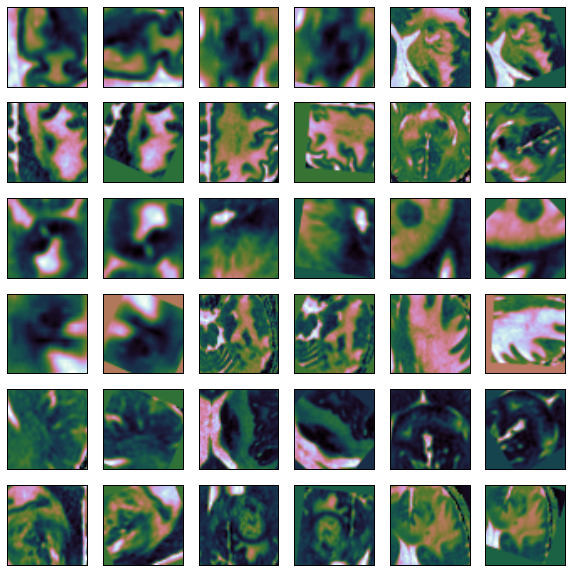

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
from skimage import transform as tf

#rots = np.deg2rad(np.asarray((90,180,0,5,-5,10,-10)))
rots = np.deg2rad(range(0,359))


def manipulateTrainingData(Xb):
    retX = np.zeros((Xb.shape[0], Xb.shape[1], Xb.shape[2], Xb.shape[3]), dtype='float32')
    for i in range(len(Xb)):
        rot = rots[np.random.randint(0, len(rots))]
        tf_rotate = tf.SimilarityTransform(rotation=rot)
        shift_y, shift_x = np.array((X.shape[2], X.shape[3])) / 2.
        tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])
        tform_rot = (tf_shift + (tf_rotate + tf_shift_inv))

        ## TODO add the transformations
        scale = np.random.uniform(0.9,1.10)
        d = tf.SimilarityTransform(scale=scale, translation=(np.random.randint(5),np.random.randint(5)))
        tform_other = (tform_rot + d)
        
        c = 0
        retX[i,c,:,:] = tf.warp(Xb[i,c,:,:], tform_other, preserve_range = True) # "Float Images" are only allowed to have values between -1 and 1
    return retX

Xb = np.copy(X[0:100,:,:,:])
Xb = manipulateTrainingData(Xb)

fig = plt.figure(figsize=(10,10))
for i in range(18):
    a=fig.add_subplot(6,6,2*i+1,xticks=[], yticks=[])
    plt.imshow(X[i,0,:,:], cmap=plt.get_cmap('cubehelix'))
    a=fig.add_subplot(6,6,2*i+2,xticks=[], yticks=[])
    plt.imshow(Xb[i,0,:,:], cmap=plt.get_cmap('cubehelix'))
    print('before {0} after {1}'.format(np.mean(X[i,0,:,:]), np.mean(Xb[i,0,:,:])))

In [11]:
PIXELS = 48
COLORS =  1 #The number of layers of the input image 1 (BW), 3 rgb, 5 for HCS data

from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

conv = (3,3)
stride = (1,1)
pool = (2,2)

num1 = 32
num2 = 64
num3 = 128
num4 = 256
num5 = 256

net_bigger = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        
        ('conv1', layers.Conv2DLayer),
        ('conv11', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        
        ('conv2', layers.Conv2DLayer),
        ('conv22', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        
        ('conv3', layers.Conv2DLayer),
        ('conv33', layers.Conv2DLayer),
#        ('pool3', layers.MaxPool2DLayer),
        
#         ('conv4', layers.Conv2DLayer),
#         ('conv44', layers.Conv2DLayer),
#         ('pool4', layers.MaxPool2DLayer),
        
#         ('conv5', layers.Conv2DLayer),
#         ('conv55', layers.Conv2DLayer),
#         ('pool5', layers.MaxPool2DLayer),
                
              
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        
        ('hidden2', layers.DenseLayer),
        ('dropout2', layers.DropoutLayer),
        
        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, COLORS, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    
    conv1_num_filters=num1, conv1_filter_size=conv, conv1_stride=stride, 
    conv11_num_filters=num1, conv11_filter_size=conv, conv11_stride=stride,
    pool1_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    conv2_num_filters=num2, conv2_filter_size=conv, conv2_stride=stride, 
    conv22_num_filters=num2, conv22_filter_size=conv, conv22_stride=stride,
    pool2_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    conv3_num_filters=num3, conv3_filter_size=conv, conv3_stride=stride, 
    conv33_num_filters=num3, conv33_filter_size=conv, conv33_stride=stride,
#    pool3_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
#     conv4_num_filters=num4, conv4_filter_size=conv, conv4_stride=stride, 
#     conv44_num_filters=num4, conv44_filter_size=conv, conv44_stride=stride,
#     pool4_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
#     conv5_num_filters=num5, conv5_filter_size=conv, conv5_stride=stride, 
#     conv55_num_filters=num5, conv55_filter_size=conv, conv55_stride=stride,
#     pool5_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    hidden1_num_units=200,
    dropout1_p=0.3,
    
    hidden2_num_units=200,
    dropout2_p=0.3,
    
    hidden3_num_units=50,
    dropout3_p=0.3,
    
    output_num_units=2, output_nonlinearity=nonlinearities.softmax,
    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=200,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

In [12]:
y[0:10], X[0,0,:,:], X[1,0,:,:], np.std(X[:,0,33,0]), np.min(y), np.max(y)


(array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32),
 array([[ 2.66857958,  2.75678086,  2.70856929, ...,  0.96610081,
          0.9720099 ,  0.72935742],
        [ 2.6214447 ,  2.65163589,  2.52336287, ...,  0.7845993 ,
          0.86632293,  0.72972691],
        [ 2.47465014,  2.46172762,  2.35132289, ...,  0.58052635,
          0.74600315,  0.69504952],
        ..., 
        [ 3.34891796,  3.57862115,  3.60170674, ...,  1.745     ,
          1.98893654,  2.02224779],
        [ 3.2032547 ,  3.46229482,  3.45525789, ...,  2.14127851,
          2.14812946,  1.92005491],
        [ 2.71793604,  3.10712862,  3.11663651, ...,  2.20494556,
          2.04392648,  1.68816447]], dtype=float32),
 array([[-0.31948477, -0.35208955, -0.39115199, ..., -0.33242357,
         -0.33315733, -0.32262257],
        [-0.33604354, -0.35781914, -0.40280196, ..., -0.32853821,
         -0.32381538, -0.33466926],
        [-0.30995825, -0.33369476, -0.37397444, ..., -0.31618097,
         -0.30261704, -0.31180775]

### With Augmentation

In [13]:
from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        #return Xb[:,:,:,::-1], yb #<--- Here we do the flipping of the images
        return manipulateTrainingData(Xb), yb
    
# Setting the new batch iterator
net1Aug = net_bigger
net1Aug.max_epochs = 200
net1Aug.batch_iterator_train = SimpleBatchIterator(50)
net1Aug = net1Aug.fit(X,y)

# Neural Network with 976984 learnable parameters

## Layer information

|   # | name     | size     |
|----:|:---------|:---------|
|   0 | input    | 1x48x48  |
|   1 | conv1    | 32x46x46 |
|   2 | conv11   | 32x44x44 |
|   3 | pool1    | 32x22x22 |
|   4 | conv2    | 64x20x20 |
|   5 | conv22   | 64x18x18 |
|   6 | pool2    | 64x9x9   |
|   7 | conv3    | 128x7x7  |
|   8 | conv33   | 128x5x5  |
|   9 | hidden1  | 200      |
|  10 | dropout1 | 200      |
|  11 | hidden2  | 200      |
|  12 | dropout2 | 200      |
|  13 | hidden3  | 50       |
|  14 | dropout3 | 50       |
|  15 | output   | 2        |

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       0.69205       0.68375      1.01213      0.60263  0.94s
      2       0.68997       0.67756      1.01832      0.60263  0.92s
      3       0.68845       0.67639      1.01783      0.60263  0.92s
      4       0.68908       0.67696      1.

/usr/local/lib/python2.7/dist-packages/Lasagne-0.1dev-py2.7.egg/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/usr/local/lib/python2.7/dist-packages/Lasagne-0.1dev-py2.7.egg/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


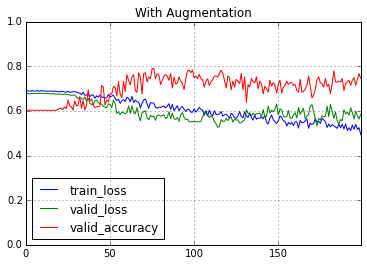

In [14]:
%matplotlib inline
import pandas as pd
dfNoAug = pd.DataFrame(net1Aug.train_history_)
dfNoAug[['train_loss','valid_loss','valid_accuracy']].plot(title='With Augmentation', ylim=(0,1))

## Using the untouched test-set

In [45]:
X_test = np.asanyarray(X_test,dtype='float32')
pred = net1Aug.predict(X_test)
np.sum(pred  == np.asanyarray(y_test - 2, dtype='int32')) / (1.0*len(y_test))

0.64088397790055252

In [16]:
pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0])

### Prediction per patient

In [57]:
import pandas as pd
df = pd.DataFrame(columns = ('Name','y_True','y_pred','p_0','p_1'))
probs = net1Aug.predict_proba(X_test)

for i, name in enumerate(Names_test):
    df.loc[i,] = (Names_test[i].split('=')[0], y_test[i]-2, pred[i], probs[i][0], probs[i][1])

In [137]:
df.head()

,Name,y_True,y_pred,p_0,p_1
0,OPS36EIZVSPOQLUNVC4WA3VENA,0,0,0.9787193,0.0212807
1,OPS36EIZVSPOQLUNVC4WA3VENA,0,0,0.9744487,0.02555133
2,OPS36EIZVSPOQLUNVC4WA3VENA,0,0,0.7830812,0.2169188
3,OPS36EIZVSPOQLUNVC4WA3VENA,0,0,0.822157,0.177843
4,OPS36EIZVSPOQLUNVC4WA3VENA,0,1,0.4316394,0.5683605


In [138]:
# http://bconnelly.net/2013/10/summarizing-data-in-python-with-pandas/
res = df.groupby('Name')
np.max((res['y_True'].max() - res['y_True'].min())) #All Names have the same group (Sanity Check should be 0)

0.0

In [170]:
y_pred_cond = res['p_1'].aggregate(np.average)
y_true_cond = res['y_True'].aggregate(np.average)
y_pred_cond, y_true_cond

(Name
 3ZRVRH77YZNVQPEEVMQVVPQ22Y    0.575708
 4OQFNM665RKCB2JY6QHRW53NIQ    0.402796
 4SMQCSO5HL4K55CNVE3X7XBGQY    0.204492
 5GGUXDSD56WN35Y72X3WNLLS6Y    0.102588
 5QVLVGJYS6DWPT6FN275GISIPA    0.636045
 6DIA73RZVP5RNLXBXQYL7A3GVU    0.246256
 6RNT2OMFCKGLKATZPHJ3VJHCDQ    0.539755
 D2AXC4GDKORUNRVTJM7LWTPHDA    0.594386
 FQ2LHBALPGJ4QATZPHJ3VJHCDQ    0.473455
 FTBJXIMUPJKSZGIQIEQUSKHOUM    0.204331
 HDQEIZAG3UXDZ6LI77L6R234IE    0.416714
 HLBT3YQDUGGCGLUNVC4WA3VENA    0.190982
 JRP74KULLKRLHS37X7D3EBUUUQ    0.657790
 LIIUITIFE4AKCF7LYFOGYFL244    0.279848
 MVEMPNQW4B7WBAFFZ3HRUCTGYI    0.544571
 N4O7DTZGUKG5YLUNVC4WA3VENA    0.592668
 OPS36EIZVSPOQLUNVC4WA3VENA    0.201991
 OQWVSS6OOEHSJVRECUOJ34KZKU    0.190493
 SHBXWFZYWGR3SHGOLRXQTMUDNI    0.376688
 V4YO7ZNXRVWOZVQINSSKSDWHLI    0.417122
 WDK76M7WQMLMJ5MPRFDA65BXKA    0.325024
 Name: p_1, dtype: float64, Name
 3ZRVRH77YZNVQPEEVMQVVPQ22Y    1
 4OQFNM665RKCB2JY6QHRW53NIQ    0
 4SMQCSO5HL4K55CNVE3X7XBGQY    0
 5GGUXDSD56WN35Y72X3WN

In [168]:
y_true_cond.values, y_pred_cond.values

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,
         1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.]),
 array([ 0.8941077 ,  0.91638762,  0.39730036,  0.22384459,  0.94242513,
         0.65565658,  0.97029448,  0.9376874 ,  0.91537505,  0.56379312,
         0.87753105,  0.30472234,  0.97874349,  0.34861812,  0.98432422,
         0.83791572,  0.56836051,  0.49777263,  0.61907315,  0.69503736,
         0.72949922]))

(0.80909090909090908, 0.80952380952380953)

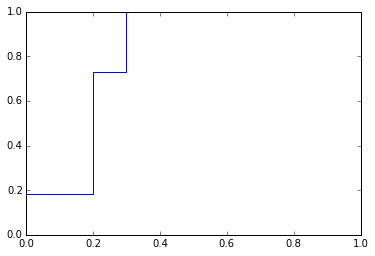

In [175]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true_cond, y_pred_cond)
plt.plot(fpr, tpr)
plt.ylim(0.0,1.0)
metrics.roc_auc_score(y_true_cond, y_pred_cond), metrics.accuracy_score(y_true_cond, y_pred_cond > 0.5)

In [173]:
np.sum(np.asarray(y_true_cond) == np.asarray(y_pred_cond_num)) / float(len(y_pred_cond_num))

0.61904761904761907

In [174]:
np.mean(y_pred_cond_num)

0.33333333333333331